# Layers

This notebook introduces a set of layers commonly found in CNNs:

- Batch Normalization
- Dropout
- Pooling



## References

### Batch Normalization
- Original paper: Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
Sergey Ioffe, Christian Szegedy
https://arxiv.org/abs/1502.03167

- Video [Why does Batch Norm work?](https://www.youtube.com/watch?v=nUUqwaxLnWs) Andrew Ng

- PyTorch: 
torch.nn.BatchNorm2d
https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html


- A Gentle Introduction to Batch Normalization for Deep Neural Networks, Jason Brownlee, https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/

### Dropout
- Original paper: Improving neural networks by preventing co-adaptation of feature detectors (2012)
G. E. Hinton∗ , N. Srivastava, A. Krizhevsky, I. Sutskever and R. R. Salakhutdinov
https://arxiv.org/pdf/1207.0580.pdf

- More evaluation: Dropout: A Simple Way to Prevent Neural Networks from Overfitting (2014)
Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever, Ruslan Salakhutdinov
https://jmlr.org/papers/v15/srivastava14a.html

- A Gentler Article: A Gentle Introduction to Dropout for Regularizing Deep Neural Networks (2018)
Jason Brownlee
https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

- Another Gentle Article: Understanding And Implementing Dropout In TensorFlow And Keras
Richmond Alake
https://towardsdatascience.com/understanding-and-implementing-dropout-in-tensorflow-and-keras-a8a3a02c1bfa


### Pooling

- Evaluation of Pooling Operations in Convolutional Architectures for Object Recognition
Dominik Scherer, Andreas Muller, and Sven Behnke
http://ais.uni-bonn.de/papers/icann2010_maxpool.pdf

- An alernative to pooling: Striving for Simplicity: The All Convolutional Net, Jost Tobias Springenberg, Alexey Dosovitskiy, Thomas Brox, Martin Riedmiller, https://arxiv.org/abs/1412.6806

- A Gentle Introduction to Pooling Layers for Convolutional Neural Networks, Jason Brownlee, https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/




In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../util')
import vcpi_util

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 128
EPOCHS = 20

cpu


In [12]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

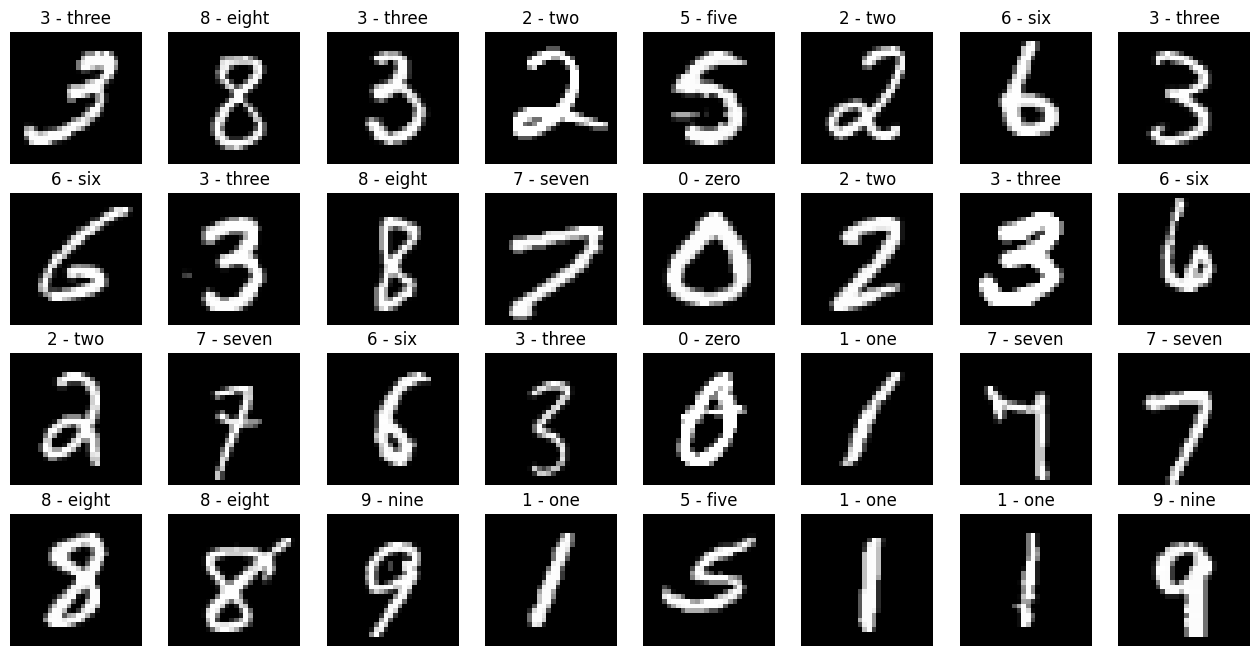

<Figure size 640x480 with 0 Axes>

In [13]:
images,targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,trainset.classes)

In [15]:
def train(model,data_loader,epochs,loss_function, optimizer):
    model.train()
    history={}
    history['accuracy'] = []
    history['loss'] = []
    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        running_loss = 0
        
        for i, (inputs,targets) in enumerate(data_loader,0):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            
            loss = loss_function(outputs,targets)
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            _,pred = torch.max(outputs,1)
            correct += (pred == targets).sum()
            running_loss +=loss
        accuracy = 100 * correct / len(trainset)
        stop_time = time.time()
        print(f"Epoch {epoch:03d}, Accuracy: {accuracy:0.4f}, Loss: {running_loss:0.4f}, Time: {(stop_time-start_time):0.4f}")
        history['accuracy'].append(accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())
    return history

In [34]:
def evaluate(model,data_loader):
    model.eval()
    correct = 0
    for i, (images,targets) in enumerate(data_loader):
        logits = model(images.to(device))
        _,pred = torch.max(logits,dim=1)
        correct += (pred.cpu() == targets).sum()
    return ((correct*100.0)/len(data_loader.dataset)).item()

In [22]:
class Conv(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 3)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.relu2 = torch.nn.ReLU()

        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.relu4 = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(19200, num_classes)
    
    def forward(self, x):
        #input = (batch_size, 1, 28, 28)
        x = self.conv1(x) # -> (batch_size, 16, 26, 26)
        x = self.relu1(x) 

        x = self.conv2(x) # -> (batch_size, 32, 24, 24)
        x = self.relu2(x) 

        x = self.conv3(x) # -> (batch_size, 48, 22, 22)
        x = self.relu3(x)

        x = self.conv4(x) # -> (batch_size, 48, 20, 20)
        x = self.relu4(x)

        x = torch.flatten(x, 1) # -> (batch_size, 19200)
        x = self.fc1(x) # -> (batch_size, num_classes)
        return x

In [23]:
model_Conv = Conv(len(trainset.classes))
model_Conv.to(device)
print(model_Conv)
torchinfo.summary(model_Conv, input_size=(BATCH_SIZE, 1, 28, 28))

Conv(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (fc1): Linear(in_features=19200, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 26, 26]         160
├─ReLU: 1-2                              [128, 16, 26, 26]         --
├─Conv2d: 1-3                            [128, 32, 24, 24]         4,640
├─ReLU: 1-4                              [128, 32, 24, 24]         --
├─Conv2d: 1-5                            [128, 48, 22, 22]         13,872
├─ReLU: 1-6                              [128, 48, 22, 22]         --
├─Conv2d: 1-7                            [128, 48, 20, 20]         20,784
├─ReLU: 1-8                              [128, 48, 20, 20]         --
├─Linear: 1-9                            [128, 10]                 192,010
Total params: 231,466
Trainable params: 231,466
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.30
Input size (MB): 0.40
Forward/backward pass size (MB): 73.41
Params size (MB): 0.93
Estimated To

In [24]:
train_acc = []

optimizer_C = torch.optim.Adam(model_Conv.parameters())
loss_function = torch.nn.CrossEntropyLoss()

history_C = train(model_Conv, train_loader, EPOCHS, loss_function, optimizer_C)

Epoch 1, Loss: 94.44699096679688, Accuracy: 93.90166473388672, Time: 119.12555456161499
Epoch 2, Loss: 25.750640869140625, Accuracy: 98.32666778564453, Time: 119.34078431129456
Epoch 3, Loss: 18.569705963134766, Accuracy: 98.7699966430664, Time: 119.80108070373535
Epoch 4, Loss: 13.834872245788574, Accuracy: 99.0183334350586, Time: 119.21206068992615
Epoch 5, Loss: 10.063065528869629, Accuracy: 99.30833435058594, Time: 115.42127394676208
Epoch 6, Loss: 8.165717124938965, Accuracy: 99.4316635131836, Time: 115.93732261657715
Epoch 7, Loss: 6.4076080322265625, Accuracy: 99.54499816894531, Time: 115.73170709609985
Epoch 8, Loss: 5.674833297729492, Accuracy: 99.58000183105469, Time: 115.54211688041687
Epoch 9, Loss: 4.666779041290283, Accuracy: 99.65333557128906, Time: 115.98664903640747
Epoch 10, Loss: 4.190366268157959, Accuracy: 99.65333557128906, Time: 115.58389043807983
Epoch 11, Loss: 3.219454765319824, Accuracy: 99.76333618164062, Time: 115.55903935432434
Epoch 12, Loss: 3.1770741939

In [35]:
train_acc.append(history_C['accuracy'][-1])

TypeError: 'NoneType' object is not subscriptable

In [36]:
eval_acc = []
eval_acc.append(evaluate(model_Conv, test_loader))
print(eval_acc)

[98.9000015258789]


In [37]:
torch.save({
    'model': model_Conv.state_dict(),
    'optimizer': optimizer_C.state_dict(),
}, f'model_conv_simple_but_cool_.pt')

In [38]:
class Conv_II(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 3)
        self.bm1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bm2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)

        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bm3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bm4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()
        
        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(768, num_classes)
    
    def forward(self, x):
        #input = (batch_size, 1, 28, 28)
        x = self.conv1(x) # -> (batch_size, 16, 26, 26)
        x = self.bm1(x)
        x = self.relu1(x) 

        x = self.conv2(x) # -> (batch_size, 32, 24, 24)
        x = self.bm2(x)
        x = self.relu2(x) 

        x = self.maxpool1(x) # -> (batch_size, 32, 12, 12)

        x = self.conv3(x) # -> (batch_size, 48, 10, 10)
        x = self.bm3(x)
        x = self.relu3(x)

        x = self.conv4(x) # -> (batch_size, 48, 8, 8)
        x = self.bm4(x)
        x = self.relu4(x)

        x = self.maxpool2(x) # -> (batch_size, 48, 4, 4)

        x = torch.flatten(x, 1) # -> (batch_size, 19200)
        x = self.fc1(x) # -> (batch_size, num_classes)
        return x
    
model_Conv_II = Conv_II(len(trainset.classes))
model_Conv_II.to(device)
print(model_Conv_II)

torchinfo.summary(model_Conv_II, input_size=(BATCH_SIZE, 1, 28, 28))

Conv_II(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (bm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (bm3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (bm4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=768, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Conv_II                                  [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 26, 26]         160
├─BatchNorm2d: 1-2                       [128, 16, 26, 26]         32
├─ReLU: 1-3                              [128, 16, 26, 26]         --
├─Conv2d: 1-4                            [128, 32, 24, 24]         4,640
├─BatchNorm2d: 1-5                       [128, 32, 24, 24]         64
├─ReLU: 1-6                              [128, 32, 24, 24]         --
├─MaxPool2d: 1-7                         [128, 32, 12, 12]         --
├─Conv2d: 1-8                            [128, 48, 10, 10]         13,872
├─BatchNorm2d: 1-9                       [128, 48, 10, 10]         96
├─ReLU: 1-10                             [128, 48, 10, 10]         --
├─Conv2d: 1-11                           [128, 48, 8, 8]           20,784
├─BatchNorm2d: 1-12                      [128, 48, 8, 8]           96
├─R

In [39]:
optimizer_C_II = torch.optim.Adam(model_Conv_II.parameters())

history_C_II = train(model_Conv_II, train_loader, EPOCHS, loss_function, optimizer_C_II)
train_acc.append(history_C_II['accuracy'][-1])

Epoch 1, Loss: 58.329219818115234, Accuracy: 96.75666809082031, Time: 71.41117691993713
Epoch 2, Loss: 16.20522689819336, Accuracy: 98.9816665649414, Time: 70.29640817642212
Epoch 3, Loss: 12.076340675354004, Accuracy: 99.20833587646484, Time: 71.65790486335754
Epoch 4, Loss: 9.250065803527832, Accuracy: 99.38500213623047, Time: 70.63662505149841
Epoch 5, Loss: 7.779272079467773, Accuracy: 99.5, Time: 77.19643712043762
Epoch 6, Loss: 6.413300037384033, Accuracy: 99.53166961669922, Time: 74.04300260543823
Epoch 7, Loss: 5.353867530822754, Accuracy: 99.64167022705078, Time: 72.31751441955566
Epoch 8, Loss: 4.131492614746094, Accuracy: 99.71499633789062, Time: 72.28468632698059
Epoch 9, Loss: 3.624511480331421, Accuracy: 99.76166534423828, Time: 74.24641060829163
Epoch 10, Loss: 3.6379380226135254, Accuracy: 99.75333404541016, Time: 77.3479232788086
Epoch 11, Loss: 2.8062326908111572, Accuracy: 99.79833221435547, Time: 74.96560740470886
Epoch 12, Loss: 3.355185031890869, Accuracy: 99.7799

TypeError: 'NoneType' object is not subscriptable

In [40]:
eval_acc.append(evaluate(model_Conv_II, test_loader))
print(eval_acc)

[98.9000015258789, 98.87000274658203]
